### <span style="color:#FFD000">Drugs: cocain, crack, marijuana | Runtime: 2-5 minutes</span>

# <span style="color:#1477d2">Imports</span>

In [1]:
import time

START_TIMER = time.time()


In [2]:
# Standard library imports
import gc
import json
import os

# Third-party imports
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, precision_recall_curve, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# <span style="color:#1477d2">Constants and help functions</span>

In [3]:
INPUT_DATA_PATH = '../data/clean_NSDUH_2015-2019.parquet'
MODELS_PATH = '../models/'
os.makedirs(MODELS_PATH, exist_ok=True)
NUMERICAL_COLUMNS = [    # Continuous variables
    'iralcfy',           # Number of days alcohol was consumed in the past year
    'irmjfy',            # Number of days marijuana was used in the past year
    'cig30use',          # Number of days cigarettes were smoked in the past month
    'irherfy',           # Number of days heroin was used in the past year
    'irmethamyfq',       # Number of days methamphetamine was used in the past year
    'wrkdhrswk2',        # Number of hours worked in the past week
    'irki17_2',          # Number of children under 18 years old in the household
    'irhhsiz2',          # Number of people in the household
    'mjrec',             # Time since the last use of marijuana
    'smklssrec',         # Time since the last use of smokeless tobacco
]
CATEGORICAL_COLUMNS = [  # Categorical variables
    'newrace2',          # Race or ethnicity of the respondent
    'irsex',             # Sex of the respondent
    'cig100lf',          # Has smoked at least 100 cigarettes in their lifetime
    'catag3',            # Age group of the respondent
    'health',            # General health condition of the respondent
    'ireduhighst2',      # Highest level of education completed
    'irpinc3',           # Income range of the household
]


In [4]:
def clear_memory():
    gc.collect()


# <span style="color:#1477d2">Data preprocessing</span>

Перш ніж ми зможемо використовувати наші дані для навчання моделей, нам потрібно зробити кілька речей:
1. Вибрати бажані ознаки (`features`)  
2. Стандартизувати/нормалізувати числові змінні  
3. Перекодувати категоріальні змінні  

Почнемо з видалення стовпчиків `crkever`, `cocever`, `mjever` і `year`.  
Ці стовпці використовувалися лише для `EDA` та не потрібні для прогнозування.

### <span style="color:#FFD000">Завантаження даних</span>

In [5]:
data = pd.read_parquet(INPUT_DATA_PATH)
data = data.drop(['crkever', 'cocever', 'mjever', 'year'], axis=1)
print(f'Dataset have: \nRows = {data.shape[0]:,} | Columns = {data.shape[1]}')


Dataset have: 
Rows = 133,619 | Columns = 18


In [6]:
data.head()


,iralcfy,catag3,health,ireduhighst2,newrace2,irsex,irpinc3,irki17_2,irmjfy,wrkdhrswk2,irhhsiz2,cig30use,irherfy,irmethamyfq,mjrec,cig100lf,smklssrec,cocaine_crack_marijuana_used
0,52.0,4.0,1.0,8.0,7.0,1.0,2.0,3.0,364.0,40.0,4.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0
1,0.0,1.0,4.0,6.0,7.0,0.0,1.0,3.0,0.0,27.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
2,52.0,3.0,1.0,10.0,1.0,0.0,4.0,2.0,0.0,38.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
3,24.0,3.0,2.0,9.0,7.0,1.0,4.0,2.0,0.0,40.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,4.0,1.0,2.0,7.0,0.0,2.0,2.0,0.0,35.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Числові змінні будуть скориговані для кожного стовпчика за допомогою функції StandardScaler(),  
яка перетворює дані таким чином, щоб середнє значення та стандартне відхилення для цього стовпчика  
дорівнювали 0 та 1 відповідно. Така стандартизація числових змінних підвищує точність нашої моделі.

$$x' = \frac{x - \mu}{\sigma}$$

### <span style="color:#FFD000">Побудова Pipeline</span>

In [7]:
# StandardScaler() applied to NUMERICAL_COLUMNS, and OneHotEncoder() applied to CATEGORICAL_COLUMNS
preprocessor = ColumnTransformer(transformers=[('numerical', StandardScaler(), NUMERICAL_COLUMNS), 
                                               ('categorical', OneHotEncoder(drop='first'), CATEGORICAL_COLUMNS)])

# Define pipeline with preprocessing and placeholder for model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', 'passthrough')])
joblib.dump(pipeline, MODELS_PATH + 'pipeline_V1.pkl') # Save the pipeline


['../models/pipeline_V1.pkl']

In [8]:
# # Load the pipeline from the file
# loaded_pipeline = joblib.load(pipeline_path)
# print(f"Pipeline loaded from {pipeline_path}")

# # Example usage of the loaded pipeline
# X_transformed = loaded_pipeline['preprocessor'].transform(X_test)
# print(f"Transformed X_test shape: {X_transformed.shape}")


In [9]:
# Define feature and target columns
features = NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS
target = 'cocaine_crack_marijuana_used'

# Standard naming conventions for feature/test datasets
X = data[features]
y = data[target]


### <span style="color:#FFD000">Розділення даних на піднабори</span>

In [10]:
# Розділення на навчальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Before preprocessing: \nX_train shape: {X_train.shape} | y_train shape: {y_train.shape}')

# Fit and transform training data, transform test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print(f'\nAfter preprocessing: \nX_train shape: {X_train.shape} | y_train shape: {y_train.shape}')

del X, y, data, features, target
clear_memory()


Before preprocessing: 
X_train shape: (106895, 17) | y_train shape: (106895,)

After preprocessing: 
X_train shape: (106895, 42) | y_train shape: (106895,)


# <span style="color:#1477d2">Models building</span>

### <span style="color:#FFD000">Models definitions</span>

##### <span style="color:#39E75F">LightGBM model</span>

In [11]:
lgb_model = lgb.LGBMClassifier(random_state=42)


##### <span style="color:#39E75F">XGBoost model</span>

In [12]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


##### <span style="color:#39E75F">Ridge Regression model</span>

In [13]:
ridge_model = RidgeClassifier(random_state=42)


##### <span style="color:#39E75F">Gradient Boosting Classifier model</span>

In [14]:
gbc_model = GradientBoostingClassifier(random_state=42)


##### <span style="color:#39E75F">Random Forest model</span>

In [15]:
rf_model = RandomForestClassifier(random_state=42)


##### <span style="color:#39E75F">Stacking Classifier model</span>

In [16]:
stack_model = StackingClassifier(estimators=[('lgb', lgb_model), 
                                             ('xgb', xgb_model),
                                             ('rf', rf_model)], 
                                 final_estimator=RidgeClassifier(random_state=42))


### <span style="color:#FFD000">Models training</span>

##### <span style="color:#39E75F">LightGBM model</span>

In [17]:
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     {lgb_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)


[LightGBM] [Info] Number of positive: 58906, number of negative: 47989
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 106895, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551064 -> initscore=0.204971
[LightGBM] [Info] Start training from score 0.204971

Model:     LGBMClassifier
Accuracy:  0.996932
Precision: 0.999931
Recall:    0.994462
F1-Score:  0.997189


##### <span style="color:#39E75F">XGBoost model</span>

In [18]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     {xgb_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)


d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:12:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model:     XGBClassifier
Accuracy:  0.996857
Precision: 0.999794
Recall:    0.994462
F1-Score:  0.997121


##### <span style="color:#39E75F">Ridge Regression model</span>

In [19]:
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     {ridge_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)



Model:     RidgeClassifier
Accuracy:  0.968867
Precision: 1.000000
Recall:    0.943119
F1-Score:  0.970727


##### <span style="color:#39E75F">Gradient Boosting Classifier model</span>

In [20]:
gbc_model.fit(X_train, y_train)
y_pred = gbc_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     {gbc_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)



Model:     GradientBoostingClassifier
Accuracy:  0.996894
Precision: 0.999863
Recall:    0.994462
F1-Score:  0.997155


##### <span style="color:#39E75F">Random Forest model</span>

In [21]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     {rf_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)



Model:     RandomForestClassifier
Accuracy:  0.996969
Precision: 1.000000
Recall:    0.994462
F1-Score:  0.997223


##### <span style="color:#39E75F">Stacking Classifier model</span>

In [22]:
stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     {stack_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)


[LightGBM] [Info] Number of positive: 58906, number of negative: 47989
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 106895, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551064 -> initscore=0.204971
[LightGBM] [Info] Start training from score 0.204971


d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:13:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 47125, number of negative: 38391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 85516, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551066 -> initscore=0.204981
[LightGBM] [Info] Start training from score 0.204981
[LightGBM] [Info] Number of positive: 47125, number of negative: 38391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 85516, number of used features: 42
[LightGBM] [Info] [bin

d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:14:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:14:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:14:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model:     StackingClassifier
Accuracy:  0.996969
Precision: 1.000000
Recall:    0.994462
F1-Score:  0.997223


### <span style="color:#FFD000">Models evaluation</span>

In [23]:
results = []
models = {'LightGBM': lgb_model,
          'XGBoost': xgb_model,
          'Ridge': ridge_model,
          'Gradient Boosting': gbc_model,
          'Random Forest': rf_model,
          'Stacking': stack_model}


In [24]:
for name, model in models.items():
    y_pred = model.predict(X_test)

    results.append({'Model': name,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred), 
                    'F1-Score': f1_score(y_test, y_pred),
                    })

print(pd.DataFrame(results))


               Model  Accuracy  Precision    Recall  F1-Score
0           LightGBM  0.996932   0.999931  0.994462  0.997189
1            XGBoost  0.996857   0.999794  0.994462  0.997121
2              Ridge  0.968867   1.000000  0.943119  0.970727
3  Gradient Boosting  0.996894   0.999863  0.994462  0.997155
4      Random Forest  0.996969   1.000000  0.994462  0.997223
5           Stacking  0.996969   1.000000  0.994462  0.997223


### <span style="color:#FFD000">Models saving</span>

In [25]:
# Save each model in the dictionary
for model_name, model in models.items():
    model_path = os.path.join(MODELS_PATH, f"{model_name.replace(' ', '_')}_V1.pkl")
    joblib.dump(model, model_path)
    print(f"Model {model_name} saved to {model_path}")


Model LightGBM saved to ../models/LightGBM_V1.pkl
Model XGBoost saved to ../models/XGBoost_V1.pkl
Model Ridge saved to ../models/Ridge_V1.pkl
Model Gradient Boosting saved to ../models/Gradient_Boosting_V1.pkl
Model Random Forest saved to ../models/Random_Forest_V1.pkl
Model Stacking saved to ../models/Stacking_V1.pkl


In [26]:
# Save feature columns as a JSON file
column_info = {'data_columns': NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS}

with open('../models/data_columns.json', 'w') as f:
    json.dump(column_info, f)

del model_name, model, model_path, column_info
clear_memory()


### <span style="color:#FFD000">Visual comparison</span>

##### <span style="color:#39E75F">Accuracy, Precision, Recall, F1-Score</span>

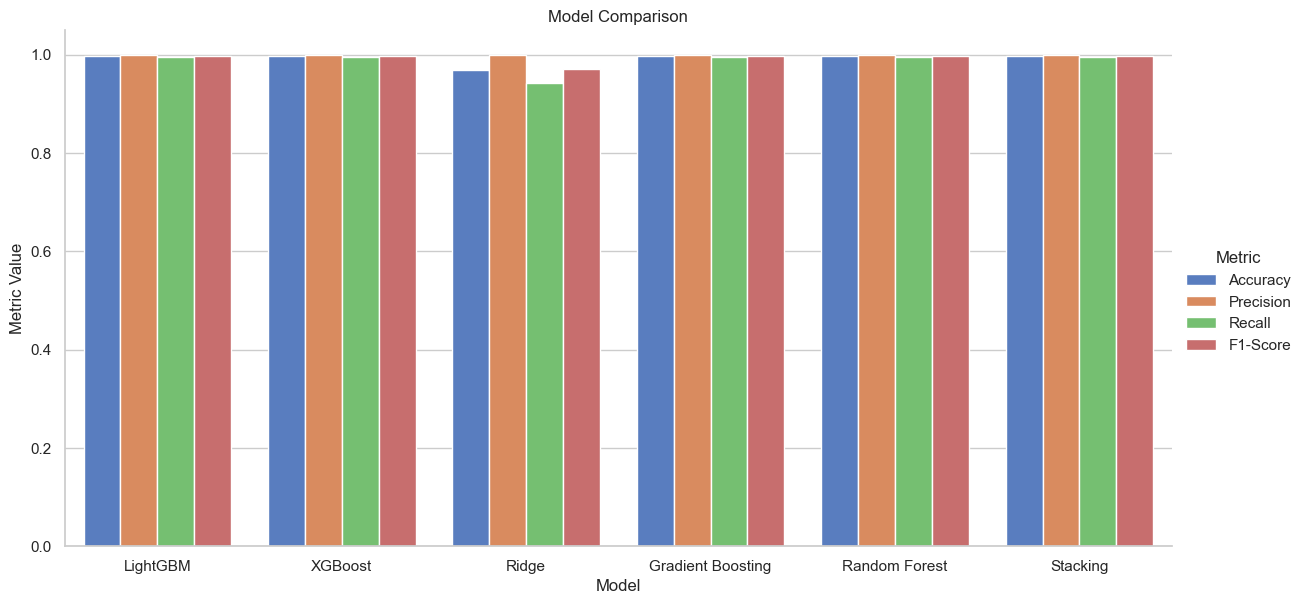

In [27]:
sns.set_theme(style="whitegrid", palette="muted")
plot = sns.catplot(data=pd.DataFrame(results).melt(id_vars="Model"), kind="bar",
                   x="Model", y="value", hue="variable", height=6, aspect=2)

plot.set_axis_labels("Model", "Metric Value")
plot.legend.set_title("Metric")
plt.title("Model Comparison")
plt.show()


##### <span style="color:#39E75F">Precision-Recall Curve, ROC Curve</span>

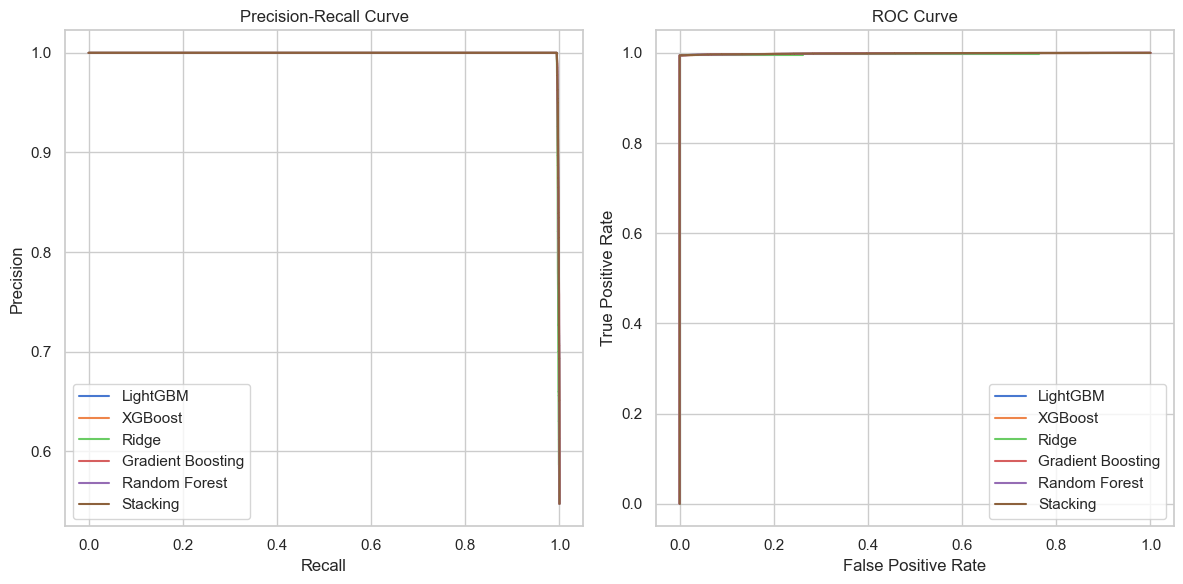

In [28]:
# Initialize the plot
plt.figure(figsize=(12, 6))

# PR Curve
plt.subplot(1, 2, 1)
for name, model in models.items():
    try:
        # Use predict_proba if available, otherwise decision_function
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            raise AttributeError(f"{name} does not support probabilities or decision scores.")
        
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        plt.plot(recall, precision, label=name)
    except AttributeError as e:
        print(e)

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

# ROC Curve
plt.subplot(1, 2, 2)
for name, model in models.items():
    try:
        # Use predict_proba if available, otherwise decision_function
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            raise AttributeError(f"{name} does not support probabilities or decision scores.")
        
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        plt.plot(fpr, tpr, label=name)
    except AttributeError as e:
        print(e)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()

del fpr, tpr, precision, recall, y_scores, plot, name, model, y_pred
clear_memory()


# <span style="color:#1477d2">Outro</span>

In [29]:
elapsed_time = time.time() - START_TIMER
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

if hours > 0:
    print(f'Elapsed time: {int(hours)} hours {int(minutes)} minutes {int(seconds)} seconds')
elif minutes > 0:
    print(f'Elapsed time: {int(minutes)} minutes {int(seconds)} seconds')
else:
    print(f'Elapsed time: {int(seconds)} seconds')
print(f'Processor:    AMD Ryzen 5 3550H with Radeon Vega')
print(f'RAM:          8.00 GB')
print(f'OS:           Windows 10 Pro')

del START_TIMER, elapsed_time, hours, remainder, minutes, seconds, f
clear_memory()


Elapsed time: 3 minutes 16 seconds
Processor:    AMD Ryzen 5 3550H with Radeon Vega
RAM:          8.00 GB
OS:           Windows 10 Pro
